<a href="https://colab.research.google.com/github/hassen8/emotion_recognition_bias_auditing/blob/master/deepface_on_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install, Import, Load dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install deepface -qqqq

In [4]:
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
import cv2
from deepface import DeepFace
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
dataset_path = "/content/drive/MyDrive/drive_bys/FER/fer2013.tar.gz"

In [5]:
!tar xvzf '/content/drive/MyDrive/drive_bys/FER/fer2013.tar.gz'

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [6]:
df = pd.read_csv("/content/fer2013/fer2013.csv")

In [7]:
emotion_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

df['emotion_label'] = df['emotion'].map(emotion_labels)

test_df = df[df['Usage'] == 'PublicTest']
print("Shape of the test_df:", test_df.shape)
test_df.head()

Shape of the test_df: (3589, 4)


,emotion,pixels,Usage,emotion_label
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest,angry
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest,disgust
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest,sad
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest,neutral
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest,happy


In [8]:
#set to numpy array for processing
X_test = []

for pixel_string in test_df['pixels']:
    pixels = [int(p) for p in pixel_string.split(' ')]
    pixels = np.array(pixels).reshape(48, 48)
    X_test.append(pixels)

X_test = np.array(X_test, dtype='uint8')
image_data = []
for img in X_test:
  image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  image_data.append(image)

In [9]:
#Prepare ytest
y_test = test_df['emotion_label'].values

print("Shape of y_test:", y_test.shape)
print("Data type of y_test:", y_test.dtype)

Shape of y_test: (3589,)
Data type of y_test: object


# Run Deepface on images

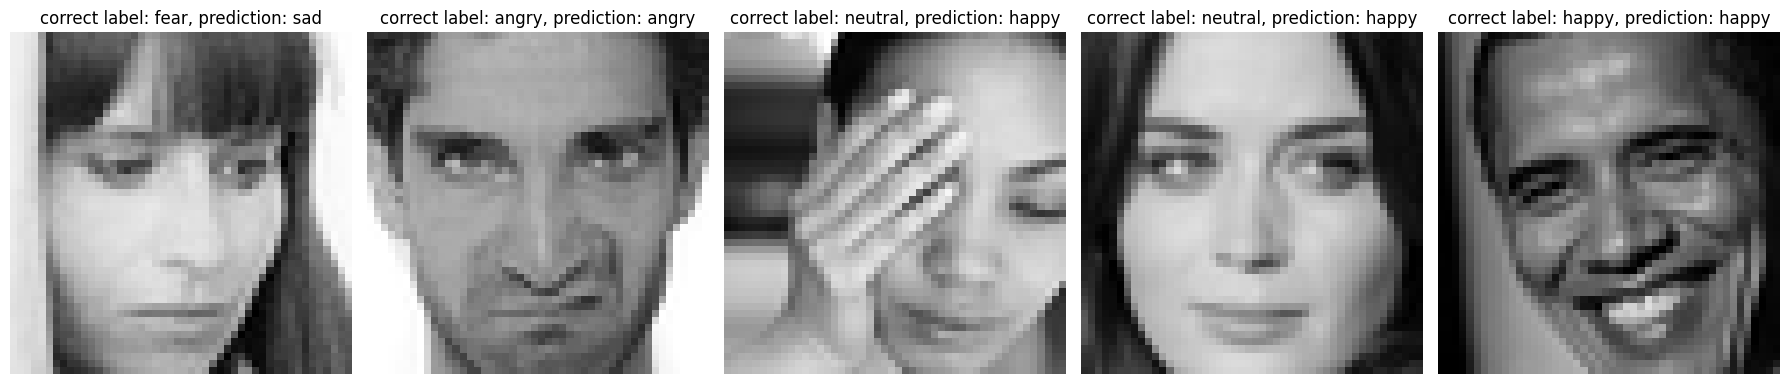

In [10]:
#predict 5 random images
plt.figure(figsize=(18, 9))
random_indices = random.sample(range(len(image_data)), 5)
for i, idx in enumerate(random_indices):
  plt.subplot(1, 5, i + 1)
  plt.imshow(image_data[idx], cmap='gray')
  results = DeepFace.analyze(image_data[idx], enforce_detection=False, actions=['emotion'])
  plt.title(f"correct label: {y_test[idx]}, prediction: {results[0]['dominant_emotion']}")
  plt.axis('off')
plt.tight_layout()
plt.show()

Predict on the whole test set

In [92]:
#run on the whole dataset (takes 11 mins on cpu for training split)
results = DeepFace.analyze(image_data, enforce_detection=False,  actions=['emotion'])

In [12]:
output_filename = 'deepface_results_FER.json'

In [93]:
#this cell saves the output of the model to your drive, incase you want to load it later
def convert_numpy_floats(obj):
    """
    Recursively converts numpy float32 objects to standard Python floats
    within dictionaries and lists.
    """
    if isinstance(obj, dict):
        return {k: convert_numpy_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_floats(elem) for elem in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

# Define the output file path
output_dir = '/content/drive/MyDrive/drive_bys/'
output_filepath = os.path.join(output_dir, output_filename)

# Convert numpy.float32 to standard floats before saving
serializable_results = convert_numpy_floats(results)

# Save the results to a JSON file
with open(output_filepath, 'w') as f:
    json.dump(serializable_results, f, indent=4)

print(f"Results saved to: {output_filepath}")

Results saved to: /content/drive/MyDrive/drive_bys/deepface_results_FER.json


In [13]:
results = json.load(open(f'/content/drive/MyDrive/drive_bys/{output_filename}'))
len(results)

3589

# Top-k, F1

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Define the exact order DeepFace uses (based on your output)
emotion_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# 2. Extract Probabilities from DeepFace Results
# results is the list of lists returned by DeepFace.analyze
# We divide by 100 because DeepFace returns 0-100, but sklearn expects 0-1
y_pred_proba = []

# Iterate through the results corresponding to your dataframe rows
for entry in results:
    # entry is a list of dicts (one per face). We take the first face [0].
    emotions_dict = entry[0]['emotion']

    # Extract values in the specific order
    probs = [emotions_dict[label] for label in emotion_order]
    y_pred_proba.append(probs)

# Convert to numpy array and normalize to 0-1 range
y_pred_proba = np.array(y_pred_proba) / 100.0

# 3. Prepare Ground Truth
# Map string labels from dataframe to integers (0-6) based on emotion_order
# le = LabelEncoder()
# le.fit(emotion_order) # Force the encoder to use our specific order
# y_true = le.transform(df['emotion_label']) # Transform your DF labels
y_true = test_df['emotion'].values
# Get hard predictions (Top-1 class index)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Probability Matrix Shape: {y_pred_proba.shape}")

Probability Matrix Shape: (3589, 7)


In [15]:
y_pred[0], y_true[0]

(np.int64(2), np.int64(0))

In [16]:
# --- 1. Top-1 Accuracy ---
top1_acc = top_k_accuracy_score(y_true, y_pred_proba, k=1)

# --- 2. Top-3 Accuracy ---
top3_acc = top_k_accuracy_score(y_true, y_pred_proba, k=3)

# --- 3. F1 Score ---
# "Macro" gives equal weight to all classes (good for checking performance on rare emotions like disgust)
# "Weighted" accounts for class imbalance
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Per-class F1 breakdown
report = classification_report(y_true, y_pred, target_names=emotion_order)

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print("-" * 30)
print("Per-Class Report:\n", report)

Top-1 Accuracy: 0.5520
Top-3 Accuracy: 0.8442
F1 Score (Macro): 0.5161
------------------------------
Per-Class Report:
               precision    recall  f1-score   support

       angry       0.48      0.43      0.45       467
     disgust       0.57      0.29      0.38        56
        fear       0.38      0.37      0.38       496
       happy       0.78      0.78      0.78       895
         sad       0.44      0.42      0.43       653
    surprise       0.76      0.69      0.73       415
     neutral       0.41      0.52      0.46       607

    accuracy                           0.55      3589
   macro avg       0.55      0.50      0.52      3589
weighted avg       0.56      0.55      0.55      3589



# Compute ECE

In [26]:
def compute_ece(y_true, y_pred_proba, n_bins=10):
    """
    Computes Expected Calibration Error (ECE) for multi-class classification.

    Args:
        y_true (array): True integer labels (N,)
        y_pred_proba (array): Predicted probabilities (N, C)
        n_bins (int): Number of bins for calibration
    """
    # 1. Get the max probability (confidence) and the predicted class for each sample
    confidences = np.max(y_pred_proba, axis=1)
    predictions = np.argmax(y_pred_proba, axis=1)

    # 2. Check correctness
    accuracies = (predictions == y_true)

    # 3. Define bin boundaries (0.0 to 1.0)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        # Find samples that fall into this confidence bin
        lower = bin_boundaries[i]
        upper = bin_boundaries[i + 1]

        # Mask for samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        prop_in_bin = np.mean(in_bin) # Proportion of samples in this bin

        if prop_in_bin > 0:
            # Accuracy in this bin: mean(correctness)
            accuracy_in_bin = np.mean(accuracies[in_bin])

            # Confidence in this bin: mean(confidence)
            confidence_in_bin = np.mean(confidences[in_bin])

            # Absolute difference * weight
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin

    return ece

# Calculate ECE
ece_score = compute_ece(y_true, y_pred_proba, n_bins=15)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.2748


# Confusion Matrix

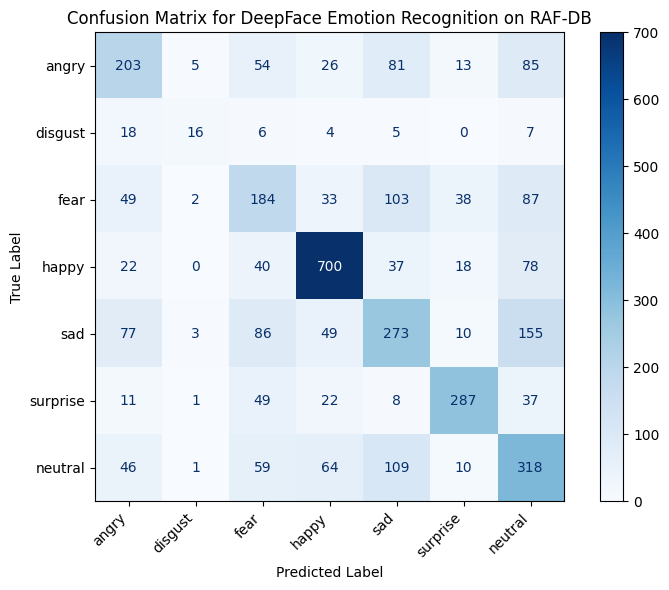

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get display labels (emotion_order is already defined in the notebook)
display_labels = emotion_order

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for DeepFace Emotion Recognition on RAF-DB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Reliability diagram

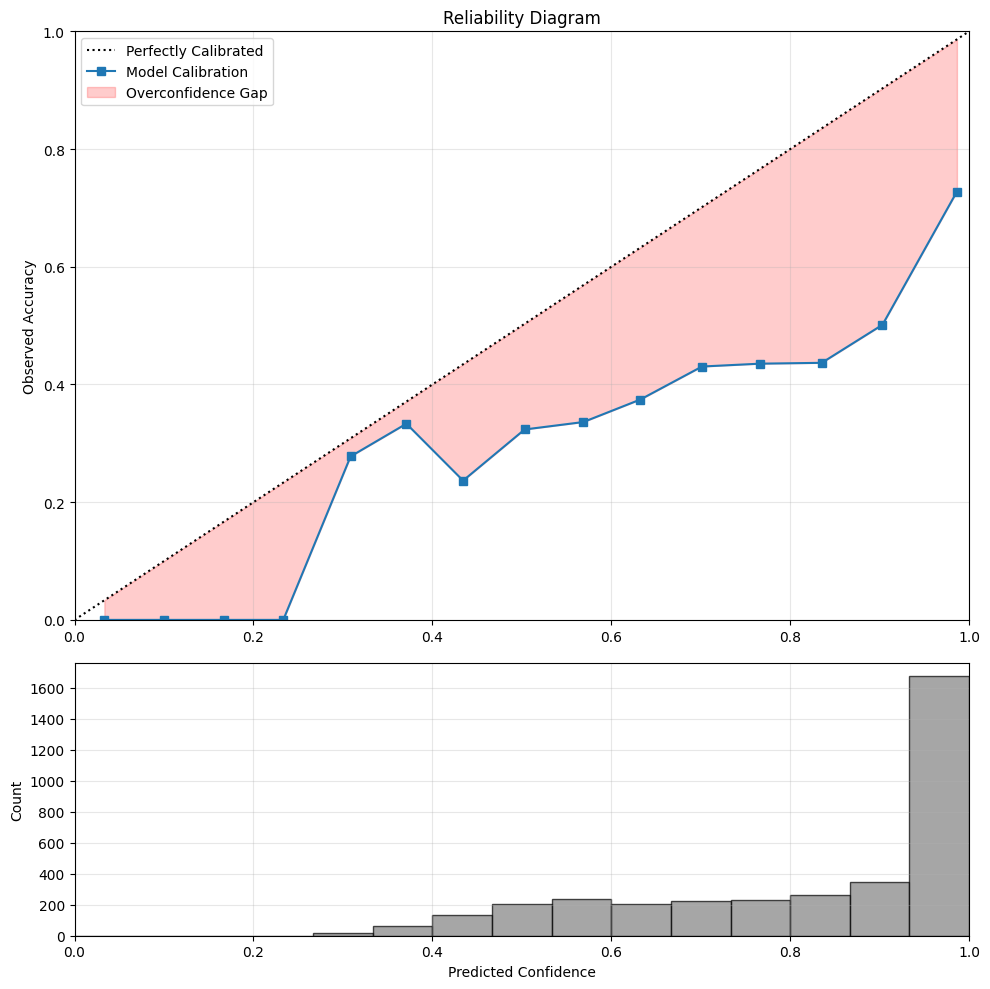

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    """
    Plots a multiclass reliability diagram.

    Args:
        y_true: Array of true class indices (0..N).
        y_prob: Array of predicted probabilities (N_samples, N_classes).
        n_bins: Number of bins for the calibration curve.
    """
    # 1. Get the Confidence (max prob) and Prediction for each sample
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)

    # 2. Determine if prediction was correct
    accuracies = (predictions == y_true)

    # 3. Create Bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for i in range(n_bins):
        # Define bin range
        lower, upper = bin_boundaries[i], bin_boundaries[i+1]

        # Find samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        count = np.sum(in_bin)
        bin_counts.append(count)

        if count > 0:
            # Calculate average accuracy and confidence for this bin
            bin_accuracies.append(np.mean(accuracies[in_bin]))
            bin_confidences.append(np.mean(confidences[in_bin]))
        else:
            bin_accuracies.append(0)
            bin_confidences.append((lower + upper) / 2)

    # --- PLOTTING ---
    plt.figure(figsize=(10, 10))

    # Subplot 1: The Reliability Curve
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    # Perfect calibration line (Diagonal)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # The Model's curve
    ax1.plot(bin_confidences, bin_accuracies, "s-", label="Model Calibration")

    # Fill areas to highlight over/under confidence
    ax1.fill_between(bin_confidences, bin_confidences, bin_accuracies,
                     where=np.array(bin_accuracies) < np.array(bin_confidences),
                     color='red', alpha=0.2, label="Overconfidence Gap")

    ax1.set_ylabel("Observed Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Confidence Histogram (How many samples in each bin?)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.hist(confidences, bins=bin_boundaries, alpha=0.7, color='gray', edgecolor='black')
    ax2.set_xlabel("Predicted Confidence")
    ax2.set_ylabel("Count")
    ax2.set_xlim([0, 1])
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
# y_true_indices: your integer ground truth (from previous step)
# y_pred_proba: your probability matrix (from previous step)

plot_reliability_diagram(y_true, y_pred_proba, n_bins=15)